# Check Data Compliance 

In [2]:
import pandas as pd
import datetime as dt
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib import rcParams
#sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
#sns.set_style("whitegrid", {'axes.grid': True})

today = date.today() 
week_ago = today - dt.timedelta(days=7)
today = today.strftime("%d%m%Y")
today = "08012024"

week_ago = week_ago.strftime("%Y-%m-%d")
week_ago = "01012024"

datapath = "/Users/leonahammelrath/FU_Psychoinformatik/Github/tiki_code/data/"
filepath = datapath + f"export_{today}.csv"


## Import Daily Scanwatch data

In [3]:
df = pd.read_csv(filepath, encoding= "latin-1")

In [4]:
df.drop(["Quelle", "Created At"], axis=1, inplace=True)

In [5]:
df["Endkunde"] = df.Endkunde.str.split("@").str.get(0)
df["Endkunde"] = df["Endkunde"].str[:4]
df.rename(columns={"Endkunde":"customer","Tag":"day", "Typ":"type","Wert(Fließkommazahl)": "float", "Wert(Ganzzahl)": "int"}, inplace=True)

In [6]:
df["day"] = pd.to_datetime(df["day"], format="%d.%m.%Y")

In [7]:
df["int"].fillna(df["float"], inplace=True)

In [8]:
df_int= df[["customer", "day", "type", "int"]]

In [9]:
df_int = df_int.pivot(
    index=["customer", "day"],
    columns="type",
    values="int")

In [10]:
df_int.reset_index(level="day", inplace=True)

In [13]:
df_int.columns

Index(['day', 'ActiveDuration', 'ActivityDuration', 'ActivityHighDuration',
       'ActivityLowDuration', 'ActivityMidDuration',
       'BreathingDisturbancesIntensity', 'BurnedCalories', 'CoveredDistance',
       'ElevationGain', 'FloorsClimbed', 'HeartRate', 'HeartRateResting',
       'HeartRateZoneIntenseDuration', 'HeartRateZoneLightDuration',
       'HeartRateZoneMaximalDuration', 'HeartRateZoneModerateDuration',
       'SleepAwakeAfterWakeup', 'SleepAwakeDuration', 'SleepDeepDuration',
       'SleepDuration', 'SleepEfficiency', 'SleepEndTime',
       'SleepInBedDuration', 'SleepIntensity', 'SleepInterruptions',
       'SleepLatency', 'SleepLightDuration', 'SleepStartTime', 'Steps'],
      dtype='object', name='type')

## Import monitoring data

In [10]:
df_active = pd.read_csv("/Users/leonahammelrath/FU_Psychoinformatik/Github/tiki_code/data/active_participants.csv")

In [11]:
df_active.rename(columns = {"Pseudonym ": "customer", "EMA ID": "ema_id", "Ende EMA Baseline": "end_ema", "Status": "status",
                            "Start EMA Baseline": "start_ema", "Studienversion":"study_version", "FOR_ID":"for_id"}, inplace=True)

In [12]:
df_active["customer"] = df_active["customer"].str[:4]

In [13]:
df_active = df_active[["customer", "ema_id", "end_ema", "start_ema", "study_version", "for_id", "status"]]

In [14]:
df_active["for_id"] = df_active.for_id.str.strip()

## Import connection data

In [15]:
filepath_connection = f"/Users/leonahammelrath/FU_Psychoinformatik/Github/tiki_code/data/export_connection_{today}.csv"
df_con = pd.read_csv(filepath_connection, encoding= "latin-1")
df_con["Customer"] = df_con.Customer.str.split("@").str.get(0)
df_con["Customer"] = df_con["Customer"].str[:4]
df_con.drop(["Data Source", "Timestamp"], axis=1, inplace=True)
df_con.rename(columns = {"Customer": "customer"}, inplace=True)

## Merge dataframes 

In [16]:
df_complete = pd.merge(df_int, df_active, on="customer")

In [17]:
df_complete = pd.merge(df_complete, df_con, on="customer")

In [18]:
grouped = df_complete.groupby(["customer"])["ema_id","for_id","start_ema","end_ema","study_version",
                                            "status","Is Connected","day"].max()

/Users/leonahammelrath/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


## Plot retention

([<matplotlib.patches.Wedge at 0x7f8da64ca350>,
 [Text(-1.0996581003842978, 0.027423753557779273, 'Kurz'),
  Text(-0.7969672130014576, -0.7581841869893421, 'Kurz (Wechsel/Abbruch)'),
  Text(1.065985013944364, -0.2714331410237782, 'Lang'),
  Text(-0.561832995210972, 0.9456974598106247, 'Lang (Wechsel)')],
 [Text(-0.599813509300526, 0.014958411031515965, '21.4%'),
  Text(-0.4347093889098859, -0.4135550110850956, '3.6%'),
  Text(0.5814463712423803, -0.14805444055842445, '64.3%'),
  Text(-0.30645436102416646, 0.5158349780785225, '10.7%')])

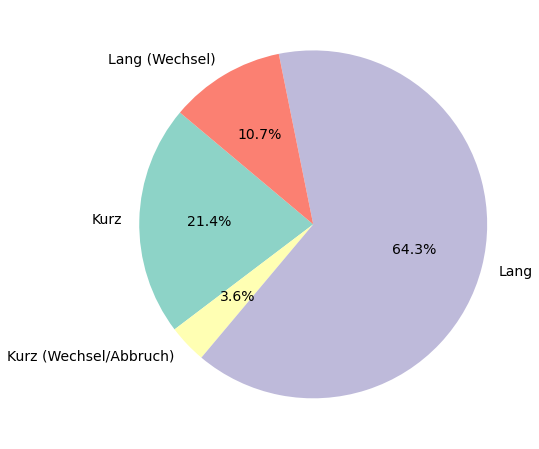

In [19]:
grouped_data = grouped.groupby("study_version")["ema_id"].count()

# Create a pie plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
sns.set_palette("Set3")  # You can choose a different color palette if needed
plt.pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})


# Show the plot
#plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
#plt.savefig("status_pie.png", dpi=300, format='png', bbox_inches='tight')

Text(0.5, 0, '')

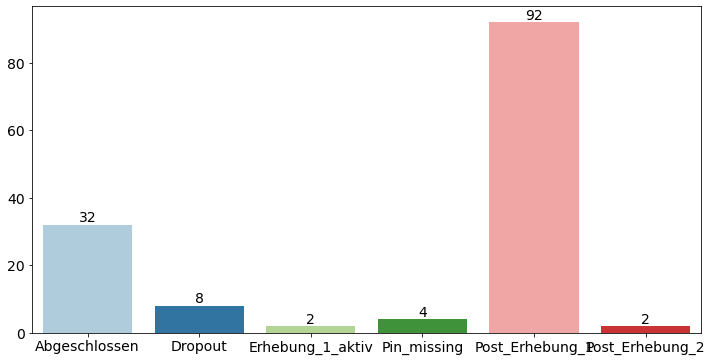

In [20]:
grouped_data = grouped.groupby("status")["ema_id"].count()

# Reset the index to make "study_version" a column
grouped_data = grouped_data.reset_index()

# Create a barplot or pointplot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.barplot(data=grouped_data, x="status", y="ema_id", palette="Paired")

for index, row in grouped_data.iterrows():
    plt.text(index, row["ema_id"], f"{row['ema_id']:}", ha="center", va="bottom", fontsize=14)

# Show the plot
plt.xticks(fontsize=14)  # Increase the fontsize of x-axis tick labels
plt.yticks(fontsize=14)  # Increase the fontsize of y-axis tick labels

plt.ylabel('')
plt.xlabel('')

# Show the plot
#plt.savefig("status_grouped.png", dpi=300, format='png', bbox_inches='tight')

In [21]:
grouped_count = df_complete.groupby(["customer"])[["day"]].count()
grouped_count.rename(columns={"day": "nr_days"}, inplace= True)

grouped_sensstart = df_complete.groupby(["customer"])[["day"]].min()
grouped_sensstart.rename(columns={"day": "start_sensing"}, inplace= True)

grouped = pd.merge(grouped, grouped_count, how= "left", on="customer")
grouped = pd.merge(grouped, grouped_sensstart, how= "left", on="customer")

date_today = pd.Timestamp('now')
grouped["start_sensing"] = pd.to_datetime(grouped["start_sensing"])

# Calculate 'max_days'
grouped["max_days"] = (date_today - grouped["start_sensing"]).dt.days


In [22]:
grouped.loc[grouped['status'] == 'Abgeschlossen', 'max_days'] = 15


In [23]:
grouped["sensing_retention"] = (grouped["nr_days"]/grouped["max_days"])*100

Text(0.5, 0, '')

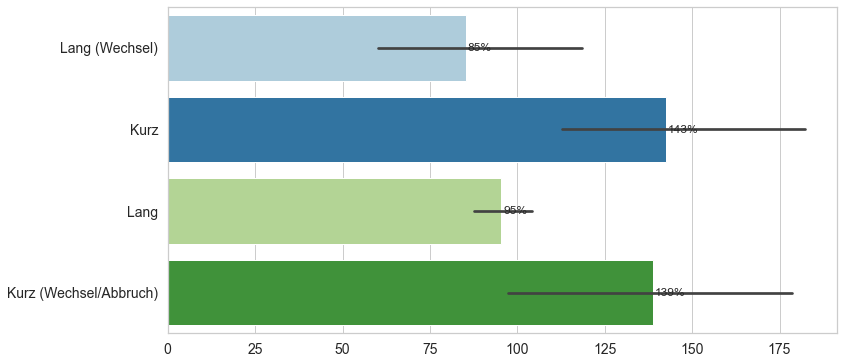

In [24]:
# If the above outputs look correct, plot again
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,6))

bar_plot = sns.barplot(
    x="sensing_retention", 
    y="study_version", 
    data=grouped, 
    palette="Paired",
    ax=ax
)

for p in bar_plot.patches:
    width = p.get_width()  # Get the width of each bar
    ax.text(p.get_x() + width + 0.5,  # X position for text
            p.get_y() + p.get_height() / 2,  # Y position for text
            '{:1.0f}%'.format(width),  # Value to annotate
            va='center')  # Vertically center the text

# Show the plot
plt.xticks(fontsize=14)  # Increase the fontsize of x-axis tick labels
plt.yticks(fontsize=14)  # Increase the fontsize of y-axis tick labels

plt.ylabel('')
plt.xlabel('')
#plt.savefig("retention_grouped.png", dpi=300, format='png', bbox_inches='tight')
# Rest of your plotting code

## Data compliance

In [25]:
grouped_active = grouped[~(grouped['status'] == "Abgeschlossen")]
grouped_active = grouped_active[~(grouped_active['status'].isin(["Dropout", "Pin_missing"]))]

In [26]:
grouped_active = grouped_active.rename_axis(None, axis=1).reset_index()

In [27]:
datapath1 = datapath + f"export_tiki_{today}/"
filepath_1 = datapath1 + "epoch_part0001.csv"
filepath_2 = datapath1 + "epoch_part0002.csv"
filepath_3 = datapath1 + "epoch_part0003.csv"
filepath_4 = datapath1 + "epoch_part0004.csv"
filepath_5 = datapath1 + "epoch_part0005.csv"
filepath_6 = datapath1 + "epoch_part0006.csv"
filepath_7= datapath1 + "epoch_part0007.csv"
filepath_8= datapath1 + "epoch_part0008.csv"
filepath_9= datapath1 + "epoch_part0009.csv"

In [28]:
df_1 = pd.read_csv(filepath_1, encoding= "latin-1")
df_2 = pd.read_csv(filepath_2, encoding= "latin-1")
df_3 = pd.read_csv(filepath_3, encoding= "latin-1")
df_4 = pd.read_csv(filepath_4, encoding= "latin-1")
df_5 = pd.read_csv(filepath_5, encoding= "latin-1")
df_6 = pd.read_csv(filepath_6, encoding= "latin-1")
df_7 = pd.read_csv(filepath_7, encoding= "latin-1")
df_8 = pd.read_csv(filepath_8, encoding= "latin-1")
df_9 = pd.read_csv(filepath_9, encoding= "latin-1")

/Users/leonahammelrath/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
df_complete = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9])
df_complete["customer"] = df_complete.customer.str.split("@").str.get(0)
df_complete["customer"] = df_complete.customer.str[:4]

In [30]:
df_complete["startTimestamp"] = pd.to_datetime(df_complete["startTimestamp"],unit='ms')
df_complete["createdAt"] = pd.to_datetime(df_complete["createdAt"],unit='ms')

df_complete["startTimestamp_day"] = df_complete.startTimestamp.dt.strftime('%Y/%m/%d')
df_complete["createdAt_day"] = df_complete.startTimestamp.dt.strftime('%Y/%m/%d')

df_complete["startTimestamp_hour"] = df_complete.startTimestamp.dt.hour
df_complete["createdAt_hour"] = df_complete.startTimestamp.dt.hour

## Import GPS Data

In [31]:
df_loc_complete = df_complete[df_complete.type.isin(["Latitude", "Longitude"])]
df_loc_complete = df_loc_complete[["customer", "startTimestamp", "type", "doubleValue", 
                           "timezoneOffset"]]

In [32]:
df_loc_merged = pd.merge(df_loc_complete, df_active, on="customer")
df_loc_merged["startTimestamp"] = (pd.to_datetime(df_loc_merged["startTimestamp"],unit='ms'))

In [33]:
df_loc_merged = df_loc_merged[~(df_loc_merged['status'].isin(["Abgeschlossen","Dropout"]))]

In [34]:
df_loc_merged = df_loc_merged.groupby("customer")[["startTimestamp"]].max().rename_axis(None, axis=1).reset_index()

## Analyse heart rate data

In [35]:
df_ecg = df_complete[df_complete.type.isin(["HeartRate", "AtrialFibrillationDetection", "RawECGVoltage"])]

In [36]:
df_ecg = df_ecg[["customer", "source", "startTimestamp", "endTimestamp", "type", "valueType", "longValue",
                "booleanValue", "stringValue", "generation", "trustworthiness", "medicalGrade", "timezoneOffset",
                "createdAt", "createdAt_day", "createdAt_hour", "startTimestamp_hour", "startTimestamp_day"]]

In [37]:
df_ecg_rate = df_ecg[df_ecg.type == "HeartRate"]
df_ecg_rate = df_ecg_rate[["customer", "source", "startTimestamp", "endTimestamp", "type", "valueType", "longValue",
                          "generation", "trustworthiness"]]

In [38]:
df_ecg_art = df_ecg[df_ecg.type == "AtrialFibrillationDetection"]
df_ecg_art = df_ecg_art[["customer", "source", "startTimestamp","type", "valueType","booleanValue", "createdAt"]]

In [39]:
df_ecg_volt = df_ecg[df_ecg.type == "RawECGVoltage"]
df_ecg_volt = df_ecg_volt[["customer", "source", "startTimestamp","type", "valueType", 
                         "stringValue", "timezoneOffset","createdAt", "createdAt_day", "createdAt_hour", 
                          "startTimestamp_hour", "startTimestamp_day"]]

In [40]:
df_ecg_volt["day_hour"] = df_ecg_volt["createdAt"].dt.strftime("%Y/%m/%d %H")
#df_ecg_volt.groupby("customer")["createdAt_day"].nunique()

In [41]:
df_ecg_volt_merged = pd.merge(df_ecg_volt, df_active, on="customer")
df_ecg_volt_merged = df_ecg_volt_merged[df_ecg_volt_merged.status.isin(["Post_Erhebung_1", "Erhebung_2_aktiv", "Abgeschlossen"])]

In [42]:
df_ecg_volt_merged["n_days_ecg"] = df_ecg_volt_merged.groupby("customer")["createdAt_day"].transform("nunique")

In [43]:
df_ecg_volt_merged.groupby("study_version")["n_days_ecg"].mean()

study_version
Kurz                      12.395161
Kurz (Wechsel/Abbruch)     9.283333
Lang                      17.546179
Lang (Wechsel)            40.848060
Name: n_days_ecg, dtype: float64

Text(0.5, 0, '')

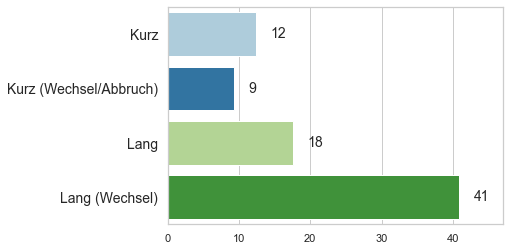

In [44]:
sns.set(style="whitegrid")
fig, ax = plt.subplots()

# Plotting
bar_plot = sns.barplot(
    x="n_days_ecg", 
    y="study_version", 
    data=df_ecg_volt_merged.groupby("study_version")["n_days_ecg"].mean().reset_index(), 
    palette="Paired",
    ax=ax
)

# Annotating bars with their values and adjusting font size
max_width = max([p.get_width() for p in bar_plot.patches])  # Find the maximum width
for p in bar_plot.patches:
    width = p.get_width()
    ax.text(width + max_width * 0.05,  # Adding a relative offset from the bar's end
            p.get_y() + p.get_height() / 2, 
            '{:1.0f}'.format(width), 
            va='center',
            fontsize=14)  # Increase fontsize here

# Adjusting the x-axis limits to make room for annotations
ax.set_xlim(0, max_width * 1.15)  # Increase x-axis limit
ax.tick_params(axis='y', labelsize=14) 

plt.ylabel('')
plt.xlabel('')

#plt.savefig("ecg _grouped.png", dpi=300, format='png', bbox_inches='tight')

## Analyze acitivity data

In [45]:
df_activity = df_complete[df_complete.type.isin(["ActiveBurnedCalories", "Steps", "ActivityType", "ActivityTypeDetail1",
                                                "ActivityTypeDetail2", "WalkBinary", "ElevationGain","FloorsClimbed", 
                                                 "BikeBinary", "ActiveBinary", "RunBinary","Weight", "Height"])]

In [46]:
df_activity = df_activity.drop(["medicalGrade", "userReliability", "chronologicalExactness", "dateValue",
                                "stringValue"], axis=1)

## Analyze sleep data

In [47]:
df_sleep = df_complete[df_complete.type.isin(['SleepAwakeBinary','SleepBinary', 'SleepLightBinary', 
                                              'SleepStateBinary','SleepDeepBinary', 'SleepInBedBinary', 
                                              'SleepREMBinary'])]

In [48]:
df_sleep = df_sleep[["customer", "source", "startTimestamp", "endTimestamp", "type", "valueType", "booleanValue", 
                    "generation", "timezoneOffset", "createdAt"]]

## Merge passive and GPS data to final df

In [49]:
df_merged_active = pd.merge(df_loc_merged, grouped_active, on="customer", how="outer")

In [50]:
df_merged_active.loc[df_merged_active["Is Connected"] == "nein"]

,customer,startTimestamp,ema_id,for_id,start_ema,end_ema,study_version,status,Is Connected,day,nr_days,start_sensing,max_days,sensing_retention
35,MYAi,2024-01-07 16:09:14,EMA4028,FOR14023,18.09.2023,02.10.2023,Lang,Post_Erhebung_1,nein,2023-12-15,172.0,2023-09-19,113.0,152.212389
40,Owip,2023-12-29 18:42:02,EMA3036,FOR13027,05.12.2023,19.12.2023,Lang,Post_Erhebung_1,nein,2023-12-30,69.0,2023-12-06,35.0,197.142857
56,eChq,2024-01-07 14:13:26,EMA3030,FOR13020,07.11.2023,21.11.2023,Lang (Wechsel),Post_Erhebung_1,nein,2023-12-30,106.0,2023-11-08,63.0,168.253968
81,p4A1,2024-01-07 20:12:14,EMA2013,FOR12010,15.09.2023,29.09.2023,Lang,Post_Erhebung_1,nein,2023-12-15,273.0,2023-09-16,116.0,235.344828
84,r7ty,2024-01-07 11:30:25,EMA3001,FOR13902,26.06.2023,10.07.2023,Lang,Post_Erhebung_1,nein,2024-01-08,579.0,2023-06-27,197.0,293.908629
90,vPEr,2023-12-12 15:21:57,EMA4010,FOR14013,10.08.2023,24.08.2023,Lang (Wechsel),Post_Erhebung_1,nein,2023-12-22,333.0,2023-08-11,152.0,219.078947


## Missing data

In [51]:
# no gps at all 

df_merged_active.loc[df_merged_active.startTimestamp.isna()].for_id.tolist()

['FOR14077', 'FOR13010', 'FOR13019', 'FOR11015', 'FOR13013']

In [52]:
# no gps since 7 days 

df_merged_active.loc[(df_merged_active.startTimestamp < week_ago) & (df_merged_active.day > week_ago)]["for_id"].tolist()

TypeError: Invalid comparison between dtype=datetime64[ns] and str

In [ ]:
# no gpspd since 7 days
df_merged_active.loc[(df_merged_active.startTimestamp < week_ago) & (df_merged_active.day < week_ago)]["for_id"].tolist()

In [ ]:
# no pd since 7 days 
df_merged_active.loc[(df_merged_active.startTimestamp > week_ago) & \
                     (df_merged_active.day < week_ago)]["for_id"].tolist()

## Deleted data

In [ ]:
list_1 = df_active.customer.tolist()
list_2 = df_complete.customer.unique().tolist()
set(list_1) - set(list_2)